# Visual Transformer with Linformer

Training Visual Transformer on *Dogs vs Cats Data*

* Dogs vs. Cats Redux: Kernels Edition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
* Base Code - https://www.kaggle.com/reukki/pytorch-cnn-tutorial-with-cats-and-dogs/
* Efficient Attention Implementation - https://github.com/lucidrains/vit-pytorch#efficient-attention

In [36]:
!pip -q install vit_pytorch linformer

## Import Libraries

In [37]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT


In [38]:
print(f"Torch: {torch.__version__}")

Torch: 2.0.1+cu117


In [39]:
class Config():
    # training_dir = "data/faces/training/"
    # data_dir = "glitch_data_filtered/cqt/myLow/"
    # training_dir = data_dir
    # testing_dir = data_dir
    weights_dir = "weights/"
    # train_batch_size = 64
    # train_number_epochs = 100
    # train_data_proportion = 0.8
    # test_data_proportion = 0.2
# Create output dir if they're not exist
if not os.path.exists(Config.weights_dir):
    os.makedirs(Config.weights_dir)


In [40]:
# Training settings
batch_size = 64
epochs = 2
lr = 3e-5
gamma = 0.7
seed = 42

In [41]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [42]:
device = 'cuda'

## Load Data

In [43]:
os.makedirs('data', exist_ok=True)

In [44]:
train_dir = 'data/train'
test_dir = 'data/test'

In [45]:
# with zipfile.ZipFile('train.zip') as train_zip:
#     train_zip.extractall('data')
    
# with zipfile.ZipFile('test.zip') as test_zip:
#     test_zip.extractall('data')

In [46]:
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [ ]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [ ]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]
print(labels)

['cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'dog'

## Random Plots

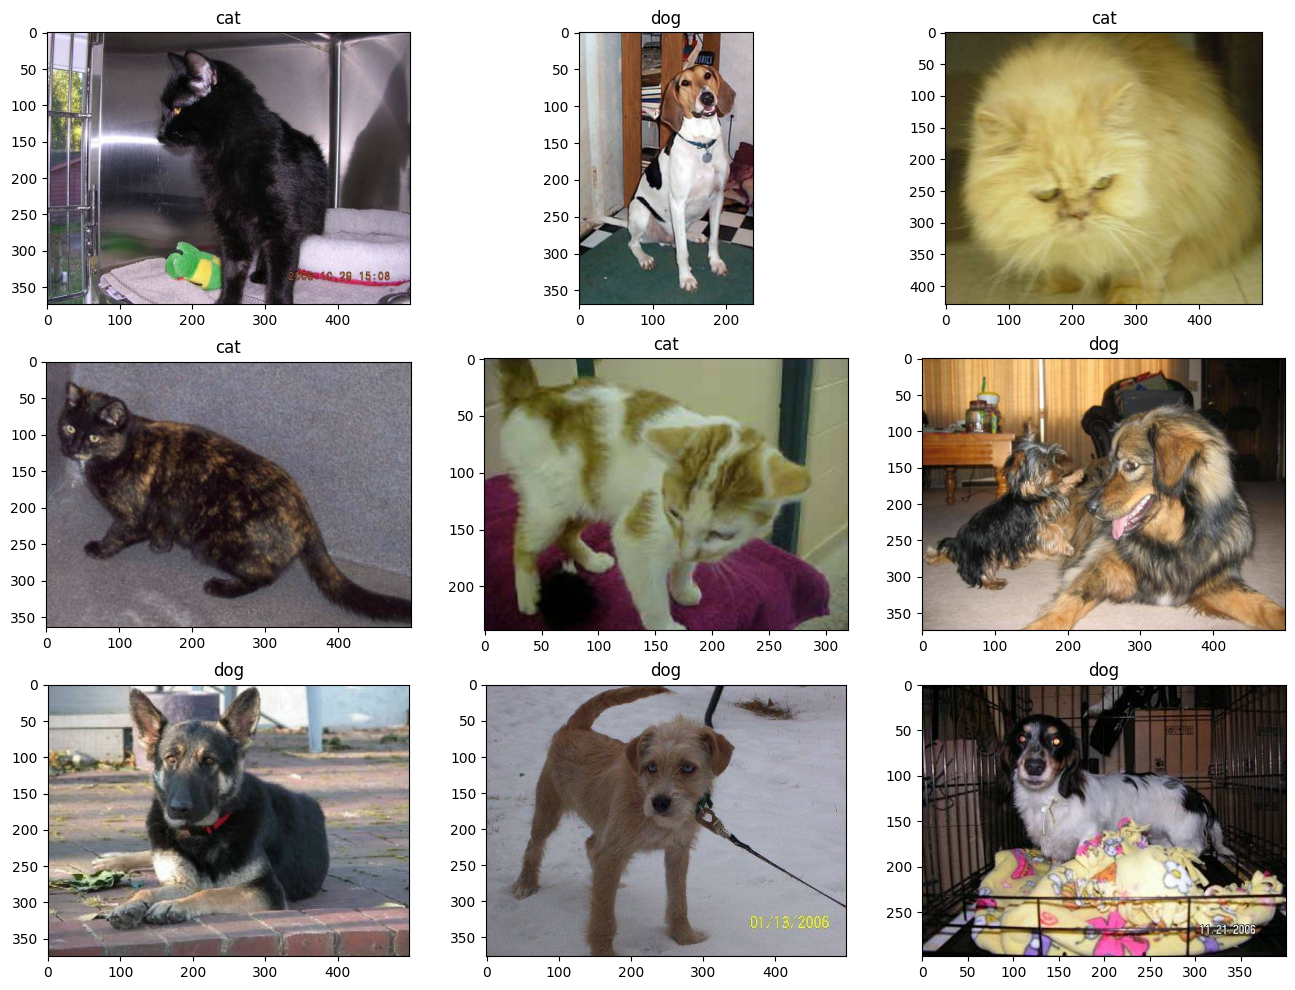

In [ ]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)


## Split

In [ ]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)

/home/guoyiyang/.conda/envs/ml/lib/python3.8/site-packages/sklearn/model_selection/_split.py:1462: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/home/guoyiyang/.conda/envs/ml/lib/python3.8/site-packages/sklearn/model_selection/_split.py:1462: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If y

In [ ]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


## Image Augmentation

In [ ]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


## Load Datasets

In [ ]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0

        return img_transformed, label


In [ ]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [ ]:
data , label  = test_data[0]
print(data.shape)

In [34]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [35]:
print(len(train_data), len(train_loader))

20000 313


In [36]:
print(len(valid_data), len(valid_loader))

5000 79


## Efficient Attention

### Linformer

In [37]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

### Visual Transformer

In [38]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

### Training

In [39]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [40]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.6921 - acc: 0.5261 - val_loss : 0.6807 - val_acc: 0.5593



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6822 - acc: 0.5509 - val_loss : 0.6664 - val_acc: 0.5906



In [46]:
print(Config.weights_dir+'epoch_{}.pth'.format(epoch))
print(model.state_dict())

weights/epoch_1.pth
OrderedDict([('pos_embedding', tensor([[[-0.1956, -0.1286,  1.7040,  ..., -0.4421, -0.6904, -1.3377],
         [-0.7739, -1.5764,  0.0183,  ...,  1.0966,  0.3873,  0.6801],
         [ 0.6262, -0.5028, -1.6580,  ..., -0.2093, -0.2095, -0.1679],
         ...,
         [ 0.8367,  0.3712,  0.3897,  ..., -0.0671,  0.2427,  1.5056],
         [ 0.4721, -0.3014,  1.0725,  ...,  0.0113, -0.1445,  0.0843],
         [-0.6430,  0.3499,  0.1349,  ..., -1.0635, -2.4555,  0.0125]]],
       device='cuda:0')), ('cls_token', tensor([[[ 9.8581e-01, -7.1125e-01,  9.0703e-01,  6.0763e-01, -2.6521e-02,
           3.2631e-01, -2.6361e-01,  2.3375e+00, -2.8700e-01, -1.2832e+00,
          -4.8822e-01,  1.3291e+00,  1.3028e+00,  1.1027e+00, -2.1253e+00,
          -2.8638e-01, -3.2631e-01,  2.1273e-01,  7.7684e-01, -1.6240e+00,
           1.4572e+00, -4.9268e-01,  6.9190e-01,  7.1420e-01, -5.0119e-01,
          -6.4494e-01,  1.5748e+00,  5.3304e-01, -1.3115e+00, -3.8188e-01,
           1.4432

In [47]:
torch.save(model.state_dict(), 'weights/test.pth')

In [48]:
print(model)

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=3072, out_features=128, bias=True)
    (3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (transformer): Linformer(
    (net): SequentialSequence(
      (layers): ModuleList(
        (0-11): 12 x ModuleList(
          (0): PreNorm(
            (fn): LinformerSelfAttention(
              (to_q): Linear(in_features=128, out_features=128, bias=False)
              (to_k): Linear(in_features=128, out_features=128, bias=False)
              (to_v): Linear(in_features=128, out_features=128, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
              (to_out): Linear(in_features=128, out_features=128, bias=True)
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (1): PreNorm(
            (fn): Fe